<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/MLP_Implementation_with_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision.datasets import MNIST
import time

In [2]:
# utils
def init_network_params(rng, sizes, scale):
  keys = random.split(rng, len(sizes))
  params = []
  for m, n, key in zip(sizes[:-1], sizes[1:], keys):
    w_key, b_key = random.split(key)
    params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
  return params

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, x, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_forward(params, x), axis=1)
  return jnp.mean(predicted_class == target_class)

In [3]:
# model
def sigmoid(x):
  #### do not work?
  return 1. / (1. + jnp.exp(-x))
  #return 0.5 + 0.5 * jnp.tanh(0.5 * x)
  #return (jnp.tanh(0.5 * x) + 1.) * 0.5

def relu(x):
  return jnp.maximum(0, x)

def forward(params, x):
  a = x
  for w, b in params[:-1]:
    z = jnp.dot(w, a) + b
    a = relu(z)
  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, a) + b_last
  return logits - logsumexp(logits)

def batched_forward(params, x):
  batched_fw = vmap(forward, in_axes=(None, 0))
  return batched_fw(params, x)

def loss(params, x, y):
  preds = batched_forward(params, x)
  return -jnp.mean(preds * y)

@jit
def update(params, lr, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]



In [4]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [9]:
batch_size = 128
num_classes = 10
model_size = [784, 512, 512, num_classes]
weight_init = 1e-2
learning_rate = 0.001
params = init_network_params(random.PRNGKey(0), model_size, scale=weight_init)

In [7]:
mnist_dataset = MNIST('./dataset/mnist', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), num_classes)

# Get full test dataset
mnist_dataset_test = MNIST('./dataset/mnist', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), num_classes)

In [10]:
tr_los = []
tr_acc = []
te_acc = []
num_epoches = 50
for epoch in range(1, num_epoches+1):
  start_time = time.time()
  for x, y in training_generator:
    y = one_hot(y, num_classes)
    params = update(params, learning_rate, x, y)
  epoch_time = time.time() - start_time

  los = loss(params, x, y)
  tr_los.append(los)
  train_acc = accuracy(params, train_images, train_labels)
  tr_acc.append(train_acc)
  test_acc = accuracy(params, test_images, test_labels)
  te_acc.append(test_acc)
  print(f"Epoch {epoch} in {epoch_time:0.2f} sec, loss {los}")
  print(f"acc@train {train_acc}, acc@test {test_acc}")
  

Epoch 1 in 2.85 sec, loss 0.08719893544912338
acc@train 0.8388167023658752, acc@test 0.8447999954223633
Epoch 2 in 2.87 sec, loss 0.05755347013473511
acc@train 0.8737833499908447, acc@test 0.8792999982833862
Epoch 3 in 2.82 sec, loss 0.04660889506340027
acc@train 0.8894333243370056, acc@test 0.8946999907493591
Epoch 4 in 2.81 sec, loss 0.04114992916584015
acc@train 0.8987666964530945, acc@test 0.9027999639511108
Epoch 5 in 2.84 sec, loss 0.03790076822042465
acc@train 0.9055666923522949, acc@test 0.9070000052452087
Epoch 6 in 2.82 sec, loss 0.035739146173000336
acc@train 0.9106333255767822, acc@test 0.9129999876022339
Epoch 7 in 2.82 sec, loss 0.03420233726501465
acc@train 0.9149166941642761, acc@test 0.917199969291687
Epoch 8 in 2.86 sec, loss 0.03300755098462105
acc@train 0.9186833500862122, acc@test 0.9215999841690063
Epoch 9 in 2.81 sec, loss 0.03206593915820122
acc@train 0.9219000339508057, acc@test 0.924299955368042
Epoch 10 in 2.82 sec, loss 0.03125756233930588
acc@train 0.924800

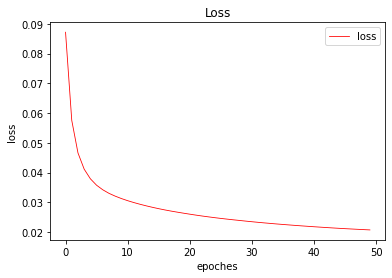

In [15]:
epoches = np.arange(0, 50, 1)
plt.figure("loss")
plt.title("Loss")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.plot(epoches, tr_los, 'r', label='loss', linewidth=0.8)
plt.legend()

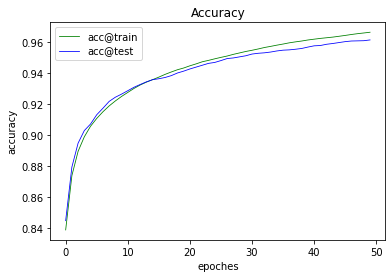

In [16]:
plt.figure("acc")
plt.title("Accuracy")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.plot(epoches, tr_acc, 'g', label='acc@train', linewidth=0.8)
plt.plot(epoches, te_acc, 'b', label='acc@test', linewidth=0.8)
plt.legend()